# Breast Cancer Classification

## In this notebook, I will use a dataset from Kaggle that includes various physical features of cells in breast cancer patients

The objective of this analysis is to explore, understand, and utilize cell features to build a classifier that will distinguish malignant from benign breast cells. I will also experiment with feature engineering using Principal Component Analysis (PCA) to see if reducing dimensionality of highly correlated features improves classifier performance.

Ted Lutkus
12/20/17

# SETUP
Before jumping into the fun stuff, I will import all the **relevant modules** that will be used as well as **peak at the dataset**.

If you would like to follow along, the dataset can be downloaded from https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data. You can save the file and replace the directory below for **df = pd.read_csv('YOUR DIRECTORY')**

In [48]:
#Allow matplotlib graphics to be displayed throughout notebook
%matplotlib inline

#Import relevant modules for data preparation and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

#Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Import modules for statistical analysis
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import bartlett

df = pd.read_csv('C:/Users/tmlut/OneDrive/Documents/Python Scripts/BreastCancerClassification/Breast_Cancer_Dataset.csv')

#First I will examine the general attributes of the data and identify any issues that
#could come up later on
df.info()
df.dtypes
df.isnull().any()

#It appears that there is a column 'Unnamed: 32' that contains only NaN values so I will just drop this along with the cell id
df = df.drop(['Unnamed: 32','id'],axis=1)

#I also will convert the 'diagnosis' column from objects to categorical data
df['diagnosis'] = df['diagnosis'].astype('category')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

# DATA EXPLORATION
Now that the dataset is stored in a Pandas dataframe, we can start with some **quick comparisons** between malignant and benign cells.

In [49]:
#Peaking at data and also check how many M and B values we have
df.head()
df['diagnosis'].value_counts() #357 B and 212 M

#Comparing M and B features by mean value
df.groupby(['diagnosis']).mean()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
M,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


From a glance, it seems that there is some difference between the mean values of each feature. Malignant cells may be larger in size than benign cells, if this difference is statistically significant then it will improve the success of our classifier.

We can look more in depth into the distributions of the data as well as the relationships between features using a **correlation matrix**. Depending on these relationships, we may seek to perform feature engineering to either introduce or summarize information being fed into our classifiers.

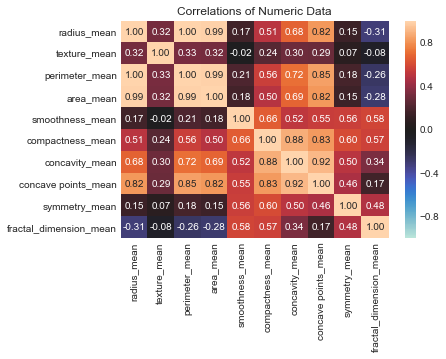

In [50]:
#I start by defining a new dataframe with only the 'mean' features because the 'se' and 'worst' features will be redundant for correlations                  
df_mean = df[['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean',
                       'concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']]
df_mean_numeric = df_mean.drop(['diagnosis'],axis=1)
corr_matrix = df_mean_numeric.corr()
sns.heatmap(corr_matrix,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f')
plt.title('Correlations of Numeric Data')

What stands out to me most from these correlations is the **incredibly strong relationships between radius, perimeter, and area**. This makes a lot of sense, however, as perimeter and area are both functions of the radius of the cell. Intuitively, we can condense this information down to the size of the cell instead of three separate features. In practice, this may not be the optimal solution for a classifier though because some information may be lost with the relationships of the three size features and the rest of our data. In this notebook, we will later explore both avenues of retaining all three features and condensing down to one.

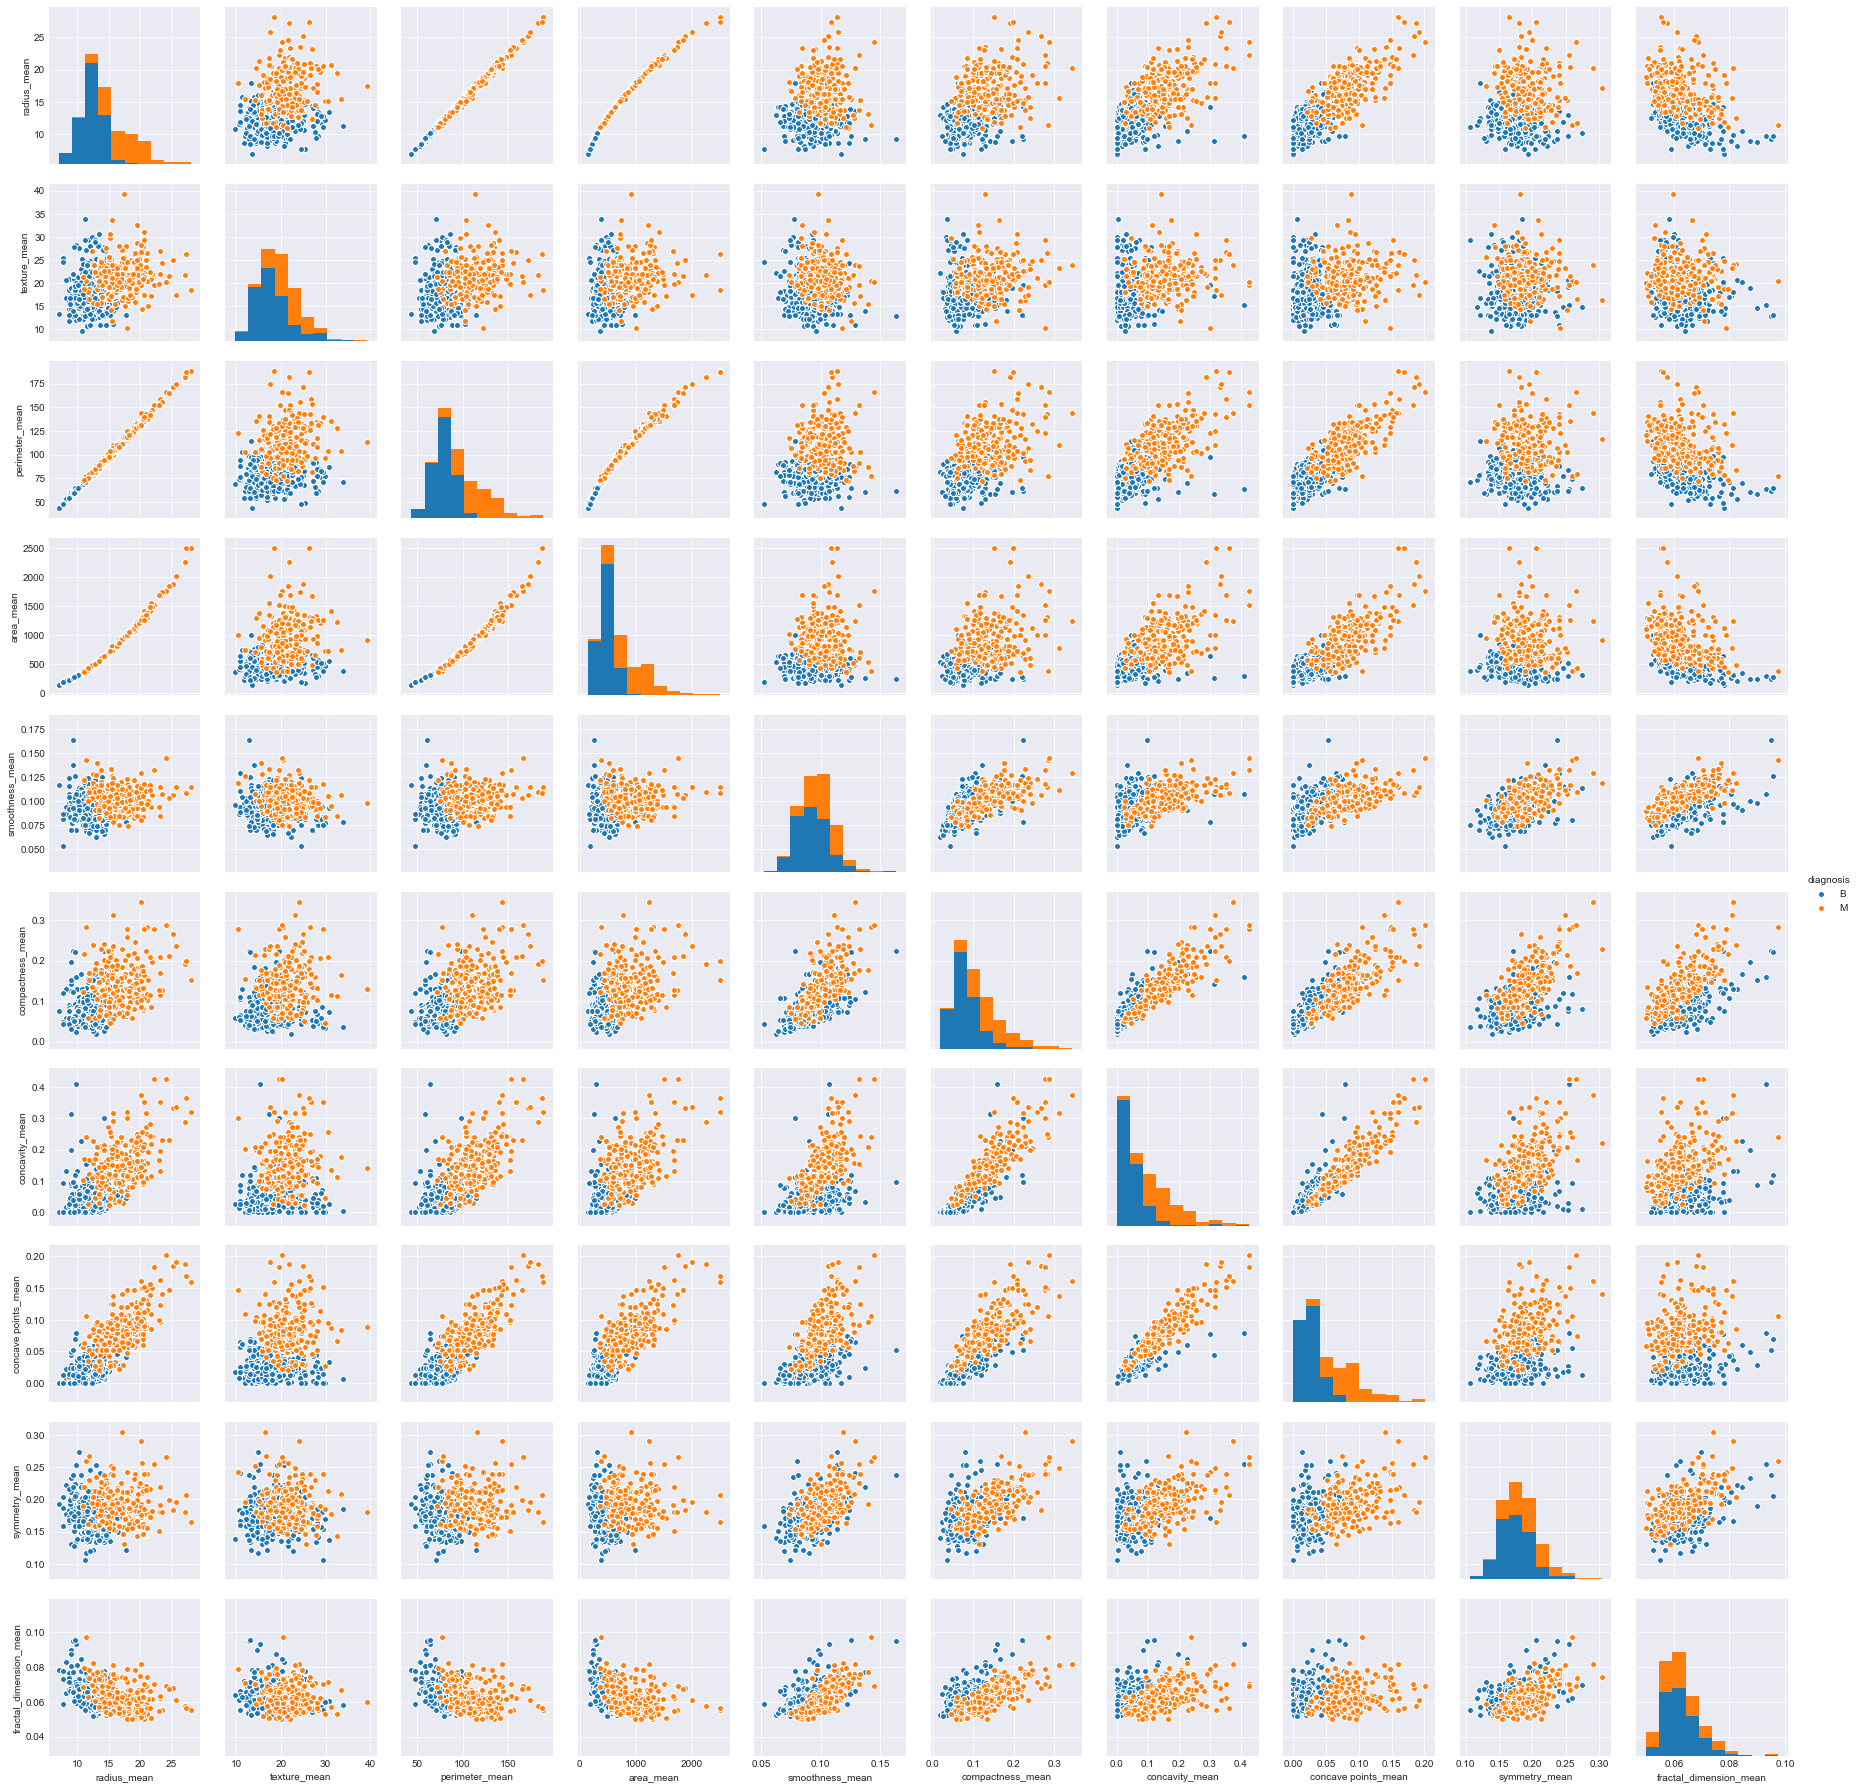

In [52]:
#Check distributions of data
sns.pairplot(data=df_mean,hue='diagnosis',vars=['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean',
                                           'concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'])

While it is difficult to see every feature within this plot, there are **a few general trends worth noting**. First, the thought from earlier that the malignant cells have greater values in magnitude is holding up in almost every scatter plot. Second, it seems that the data strays away from a normal distribution with a high early peak that decays slowly with greater magnitudes of values. Finally, we can see again that the size-related features are strongly correlated with each other with some slight nonlinearity too.

# DIMENSIONALITY REDUCTION
Due to the near perfect correlation between radius, perimeter, and area, I suspect that these features can be described thoroughly by one term. While Principal Component Analysis (PCA) is typically used for larger dimensionality reduction, I will use it here to find projections of the three features onto a one dimensional vector. At the end of this analysis, **I will compare models with and without PCA to see whether or not there was improvement in prediction accuracy**


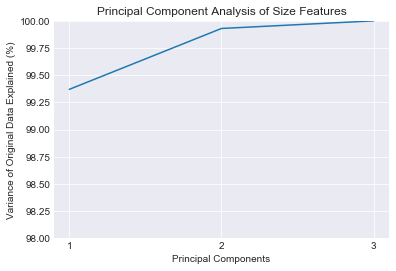

In [53]:
#Create a numpy array
arr_PCA = df[['radius_mean','perimeter_mean','area_mean']].values

#Scale the values
arr_PCA = scale(arr_PCA)

#Fitting
pca = PCA(n_components=3)
pca.fit(arr_PCA)

#Calculate the variance explained by each reduced dimension
var = pca.explained_variance_ratio_

#Cumulative variance calculated and plotted
var_c = np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
plt.plot([1,2,3],var_c)
plt.xticks([1,2,3])
plt.ylim([98,100])
plt.title('Principal Component Analysis of Size Features')
plt.ylabel('Variance of Original Data Explained (%)')
plt.xlabel('Principal Components')

Reducing down to one principal component, about 99.375% of the variance in the data is still explained. For this analysis, I think it will be interesting to **take one principal component** and compare that to using all three features.

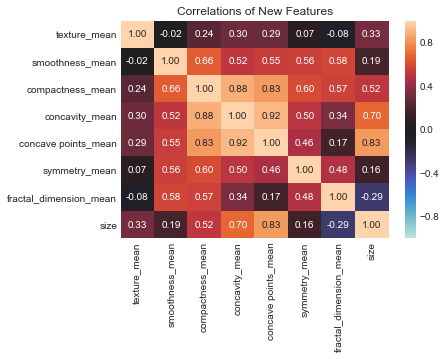

In [54]:
#Taking PCA with one principal component
pca1 = PCA(n_components=1)
arr_PCA1 = pca1.fit_transform(arr_PCA)

#Save the dataframe without PCA for later comparison in model prediction accuracy
df_mean_noPCA = df_mean

#Replace the old feature with the new 'size' feature
df_mean_new = df_mean.drop(['radius_mean','perimeter_mean','area_mean'],axis=1)
df_mean_new['size'] = arr_PCA1

#Redraw the correlation matrix to check that the size feature
#resembles the previous features
corr_matrix1 = df_mean_new.corr()
sns.heatmap(corr_matrix1,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f')
plt.title('Correlations of New Features')

# CLASSIFICATION MODELS AND TRAINING
For this problem, I have chosen **five models** that I am familiar with to train. I will iterate through 1000 different random states to train the models and discern, with more statistical power, which models perform best with this dataset.

1. Logistic Regression
2. Support Vector Machine
3. K-Nearest Neighbor
4. Gaussian Naive Bayes
5. Random Forest

In [ ]:
#Replacing the M and B strings in 'diagnosis' with binary values (M=1 B=0)
df_mean_new['diagnosis'] = df_mean_new['diagnosis'].map({'B':0,'M':1}).astype(int)
df_mean_noPCA['diagnosis'] = df_mean_new['diagnosis']

#Splitting input and target data
X = df_mean_new.drop(['diagnosis'],axis=1)
y = df_mean_new['diagnosis']
X_noPCA = df_mean_noPCA.drop(['diagnosis'],axis=1)
y_noPCA = y

#Run through 1000 trained models with a new random state on each pass
acc = []
classifier = []
PCA_Ind = []
for i in range(0,1000):
    #Setting up training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
    X_train_noPCA, X_test_noPCA, y_train_noPCA, y_test_noPCA = train_test_split(X_noPCA,y_noPCA,random_state=i)
    
    #Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    acc.append(logreg.score(X_train,y_train)*100)
    classifier.append('Logistic Regression')
    PCA_Ind.append('Yes')
    
    #Logistic Regression w/o PCA
    logreg.fit(X_train_noPCA,y_train_noPCA)
    y_pred_noPCA = logreg.predict(X_test_noPCA)
    acc.append(logreg.score(X_train_noPCA,y_train_noPCA)*100)
    classifier.append('Logistic Regression')
    PCA_Ind.append('No')
    
    #Support Vector Machine
    svc = SVC()
    svc.fit(X_train,y_train)
    y_pred = svc.predict(X_test)
    acc.append(svc.score(X_train,y_train)*100)
    classifier.append('Support Vector Machine')
    PCA_Ind.append('Yes')
    
    #Support Vector Machine w/o PCA
    svc.fit(X_train_noPCA,y_train_noPCA)
    y_pred_noPCA = svc.predict(X_test_noPCA)
    acc.append(svc.score(X_train_noPCA,y_train_noPCA)*100)
    classifier.append('Support Vector Machine')
    PCA_Ind.append('No')
    
    #K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    acc.append(knn.score(X_train,y_train)*100)
    classifier.append('K-Nearest Neighbors')
    PCA_Ind.append('Yes')
    
    #K-Nearest Neighbors w/o PCA
    knn.fit(X_train_noPCA,y_train_noPCA)
    y_pred_noPCA = knn.predict(X_test_noPCA)
    acc.append(knn.score(X_train_noPCA,y_train_noPCA)*100)
    classifier.append('K-Nearest Neighbors')
    PCA_Ind.append('No')
    
    #Gaussian Naive Bayes
    gaussian = GaussianNB()
    gaussian.fit(X_train,y_train)
    y_pred = gaussian.predict(X_test)
    acc.append(gaussian.score(X_train,y_train)*100)
    classifier.append('Gaussian Naive Bayes')
    PCA_Ind.append('Yes')
    
    #Gaussian Naive Bayes w/o PCA
    gaussian.fit(X_train_noPCA,y_train_noPCA)
    y_pred_noPCA = gaussian.predict(X_test_noPCA)
    acc.append(gaussian.score(X_train_noPCA,y_train_noPCA)*100)
    classifier.append('Gaussian Naive Bayes')
    PCA_Ind.append('No')
    
    #Random Forest
    random_forest = RandomForestClassifier(n_estimators=10)
    random_forest.fit(X_train,y_train)
    y_pred = random_forest.predict(X_test)
    acc.append(random_forest.score(X_train,y_train)*100)
    classifier.append('Random Forest')
    PCA_Ind.append('Yes')
    
    #Random Forest w/o PCA
    random_forest.fit(X_train_noPCA,y_train_noPCA)
    y_pred_noPCA = random_forest.predict(X_test_noPCA)
    acc.append(random_forest.score(X_train_noPCA,y_train_noPCA)*100)
    classifier.append('Random Forest')
    PCA_Ind.append('No')

# PERFORMANCE EVALUATION
Now that we have trained the classifiers and stored results, we can visualize them in a boxplot to reveal **which classifier is best able to predict malignant versus benign cells on unseen test data.**

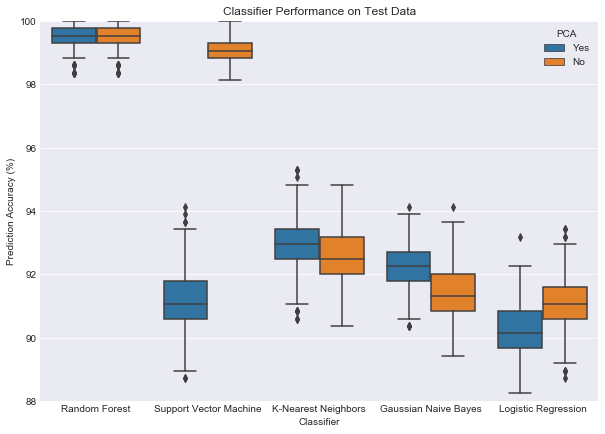

In [57]:
#Setup lists and assign columns in dataframe
data = {'Classifier':classifier,
        'PCA':PCA_Ind,
        'Prediction Accuracy':acc}
df_results = pd.DataFrame(data)
df_results = df_results.sort_values('Prediction Accuracy',ascending=False)

sns.set_style('darkgrid')
sns.boxplot(x='Classifier',y='Prediction Accuracy',data=df_results,hue='PCA')
plt.title('Classifier Performance on Test Data')
plt.ylabel('Prediction Accuracy (%)')
plt.xlabel('Classifier')
plt.ylim([88,100])
plt.rcParams["figure.figsize"] = [10,7]

What is immediately clear is that the **Random Forest** classifiers performed best with prediction accuracy with and without PCA. Interstingly, **the implementation of PCA had varying impact** on the models with improved accuracy in some cases and reduced accuracy in others. This suggests that this problem in particular is not well suited for PCA or that PCA more generally should be seen as a case-by-case tool as opposed to an automatic solution for feature redundancy. This motivates me to revist PCA and understand more nuances of its application

We will now **examine the results of the Random Forest classifiers** and evaluate if the difference in their mean performance is significant. We can do this by first checking for equal variance and then performing a two sample T-test with the null hypothesis that the two classifiers come from sample distributions with equal means.

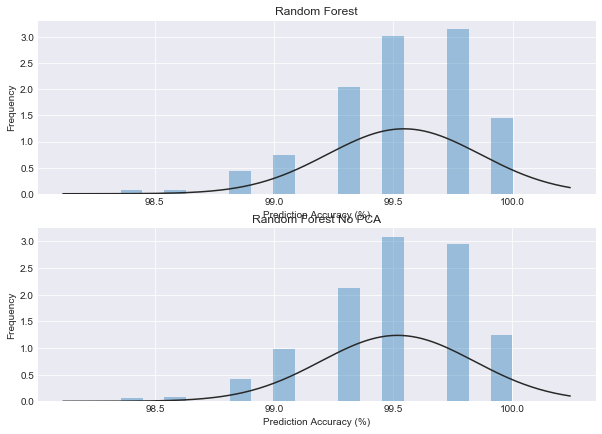

In [60]:
#Format arrays of prediction accuracy for PCA vs w/o PCA
df_random_forest = df_results.loc[(df_results['Classifier']=='Random Forest') & (df_results['PCA']=='Yes')]
df_random_forest_noPCA = df_results.loc[(df_results['Classifier']=='Random Forest') & (df_results['PCA']=='No')]
arr_random_forest = df_random_forest['Prediction Accuracy'].values
arr_random_forest_noPCA = df_random_forest_noPCA['Prediction Accuracy'].values

#Check the distribution of results
plt.subplot(2,1,1)
sns.distplot(arr_random_forest,fit=norm,kde=False)
plt.title('Random Forest')
plt.ylabel('Frequency')
plt.xlabel('Prediction Accuracy (%)')
plt.subplot(2,1,2)
sns.distplot(arr_random_forest_noPCA,fit=norm,kde=False)
plt.title('Random Forest No PCA')
plt.ylabel('Frequency')
plt.xlabel('Prediction Accuracy (%)')

The training resulted in models that converge at several discrete prediction accuracies so it is difficult to firmly say if they come from a normal distribution. I am going to assume, however, that the results do follow a normal distribution as the main reason why it would not is if the training sometimes converged at local minima which does not appear to have happened.

Now we can **use Bartlett's test** with the null hypothesis that the PCA and non-PCA results have **equal variance**. This step is needed because the two sample T-test will assume equal variance.

In [62]:
#Perform Bartlett's test for equal variances
_,pval_variance = bartlett(arr_random_forest,arr_random_forest_noPCA)
print(pval_variance)

0.854664092006


The p-value returned is high, much greater than 0.05, so **we fail to reject the null** and can statistically say that the two classifier results have equal variance. Finally, we can **use a two sample T-test** to determine if there is a statistically significant difference in the mean value of the two classifiers.

In [63]:
#Perform two sample T-test for equal means
_,pval_ttest = ttest_ind(arr_random_forest,arr_random_forest_noPCA)
print(pval_ttest)

0.0704348277166


The p-value returned by the test is also greater than 0.05 which means **we fail to reject the null** hypothesis and show statistically that **the difference in means of the PCA and non-PCA Random Forest classifiers is not significant.**

# CONCLUSION

In this analysis we have **successfully built classifiers to predict malignant and benign cancer cells**. Of these classifiers, **Random Forest has stood out with high prediction accuracy on test data**. In addition to classification accuracy among different algorithms, we also have investigated the use of PCA to combine data features with strong correlations. As was seen in our results, **PCA did not uniformly increase prediction accuracy in classification**. In the case of the Random Forest classifiers, we demonstrated that PCA did not provide statistically significant changes in mean prediction accuracy. It can be speculated that while PCA helped in some instances by reducing redundant features, it also impeded other algorithms by sacrificing some of the information for smaller data dimensionality. This effect has encouraged me to see PCA as not method to be blanketed onto correlated data but more of a case by case tool. A peer of mine has also suggested that I look into Linear Discriminant Analysis (LDA) as a technique that could have benefited this analysis.